In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import os
import sys
import umap
import time

from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append("../profiling/")
import profiling

In [2]:
PROJECT_ROOT = "/raid/data/cellpainting/TAORF/"

EXP = "30epochs_lr0005const_bs32_aug"

PERT_NAME = "pert_name"
CTRL_NAME = "EMPTY_"

REG_PARAM = 1e-2

CORR_MATRIX = "data/efn_plate_grouping_8bs_lr1e-2-conv6a.csv"

In [3]:
# Load metadata
metadata = pd.read_csv(os.path.join(PROJECT_ROOT, "inputs/metadata/index_taorf_minus2wells.csv"))
Y = pd.read_csv("data/TAORF_MOA_MATCHES.csv")
profiles = pd.merge(metadata, Y, left_on="broad_sample", right_on="Var1")
meta = pd.concat((profiles, metadata[metadata[PERT_NAME] == CTRL_NAME]), axis=0).reset_index()

# Main Function - Find first hits

In [4]:
def find_first_hits(features, feats, pert_name, control):
    results = []

    gen = features[features[pert_name] != control].groupby(["Metadata_Plate", "Metadata_Well", pert_name])["val"].count().reset_index().iterrows()
    for k, r in tqdm(gen):
        # Select samples in a well
        s = time.time()
        well = features.query(f"Metadata_Plate == {r.Metadata_Plate} & Metadata_Well == '{r.Metadata_Well}'").index
        A = np.asarray(features.loc[well,feats])

        # Get cells in other wells
        others = features.query(f"Metadata_Plate != {r.Metadata_Plate} | Metadata_Well != '{r.Metadata_Well}'").index
        B = np.asarray(features.loc[others,feats])

        # Compute cosine similarity
        C = np.dot(A, B.T)
        An = np.linalg.norm(A, axis=1)
        Bn = np.linalg.norm(B, axis=1)
        cos = C / (An[:,np.newaxis] @ Bn[:,np.newaxis].T)

        # Rank cells in other wells
        ranking = np.argsort(-cos, axis=1)

        # Find first hits
        H = np.asarray(features.loc[others, pert_name]  == r[pert_name], dtype=np.uint8)
        for h in range(len(well)):
            hit = np.where(H[ranking[h]] == 1)[0][0]
            results.append({"Metadata_Plate":r.Metadata_Plate, 
                            "Metadata_Well":r.Metadata_Well, 
                            "pert_name":r.pert_name,
                            "first_hit": hit,
                           })
    return pd.DataFrame(data=results)

# Summary statistics
### Coefficient of variation: std/mean. 
Used to assess risk in finances. If variation is greater than the mean, the investment is too risky (below 1 is good)
### Signal to noise ratio: mean/std. 
Used in image processing.
If mean is greater than variance there is signal (above 1 is good)

In [5]:
def summarize(results):
    summary = results.groupby([PERT_NAME])["first_hit"].mean().reset_index()
    summary["std"] = results.groupby([PERT_NAME])["first_hit"].std().reset_index()["first_hit"]
    summary["top_percent"] = (summary["first_hit"] / len(results))*100
    summary["percent_group"] = np.ceil(summary["top_percent"])
    summary["coef_var"] = summary["std"] / summary["first_hit"]
    summary["signal_noise"] = summary["first_hit"] / summary["std"]
    return summary

In [6]:
def visualize(summary):
    plt.figure(figsize=(10,5))
    summary = summary.sort_values("first_hit")
    sb.barplot(data=summary, x=PERT_NAME, y="top_percent")
    print("Treatments with hits in the top 1%:", summary[summary["top_percent"] <= 1].shape[0])
    plt.show()
    return summary

# Load single-cell data

In [7]:
features = []
for i in tqdm(meta.index):
    filename = PROJECT_ROOT + "outputs/" + EXP + "/features_conv6a/{}/{}/{}.npz"
    filename = filename.format(
        meta.loc[i, "Metadata_Plate"], 
        meta.loc[i, "Metadata_Well"], 
        meta.loc[i, "Metadata_Site"]
    )
    if os.path.isfile(filename):
        with open(filename, "rb") as data:
            info = np.load(data)
            features.append(info["features"])
    else:
        features.append([])

100%|██████████| 10835/10835 [00:28<00:00, 374.19it/s]


In [8]:
total_single_cells = 0
for i in range(len(features)):
    if len(features[i]) > 0:
        total_single_cells += features[i].shape[0]

print("Total images",len(features),features[0].shape)
print("Total single cells:", total_single_cells)

Total images 10835 (40, 672)
Total single cells: 814518


In [9]:
cols = ["Metadata_Plate","Metadata_Well","Metadata_Site","gene_name","pert_name","broad_sample","pert_name_replicate","val"]
sc_features = np.zeros((total_single_cells, features[0].shape[1]))
sc_meta_idx = []
k = 0
for i in tqdm(range(len(features))):
    cells = features[i].shape[0]
    sc_features[k:k+cells,:] = features[i]
    sc_meta_idx += [i]*cells
    k += cells

sc_meta = pd.merge(pd.DataFrame(sc_meta_idx, columns=["ID"]), meta[cols], left_on="ID", right_index=True)

100%|██████████| 10835/10835 [00:03<00:00, 2782.55it/s]


In [10]:
feats = [x for x in range(sc_features.shape[1])]

In [11]:
sc_controls = sc_meta[sc_meta[PERT_NAME] == CTRL_NAME]
sc_treatments = sc_meta[sc_meta[PERT_NAME] != CTRL_NAME]

In [12]:
sc_controls.shape, sc_treatments.shape

((120892, 9), (693626, 9))

# Select a sample of single cells

In [13]:
sc_sample = []
gen = sc_treatments.groupby(["Metadata_Plate", "Metadata_Well", "pert_name"])["val"].count().reset_index().iterrows()
for k,r in tqdm(gen):
    sc_sample.append(sc_treatments.query(f"Metadata_Plate == {r.Metadata_Plate} & Metadata_Well == '{r.Metadata_Well}'").sample(10))

1029it [00:26, 38.69it/s]


In [14]:
sc_sample = pd.concat(sc_sample)
sc_sample.shape

(10290, 9)

# Single-cell analysis

In [15]:
# Batch correction
sc_control_features = pd.merge(sc_controls, pd.DataFrame(data=sc_features), how="left", left_index=True, right_index=True)
whN = profiling.WhiteningNormalizer(sc_control_features[feats], reg_param=REG_PARAM)

(672,) (672, 672)


In [16]:
# Profiling
sc_sample_features = pd.merge(sc_sample, pd.DataFrame(data=sc_features), how="left", left_index=True, right_index=True)
whD = whN.normalize(sc_sample_features[feats])
sc_sample_features[feats] = whD

In [17]:
# Evaluation
sc_results = find_first_hits(sc_sample_features, feats, PERT_NAME, CTRL_NAME)

1029it [03:59,  4.30it/s]


Treatments with hits in the top 1%: 21


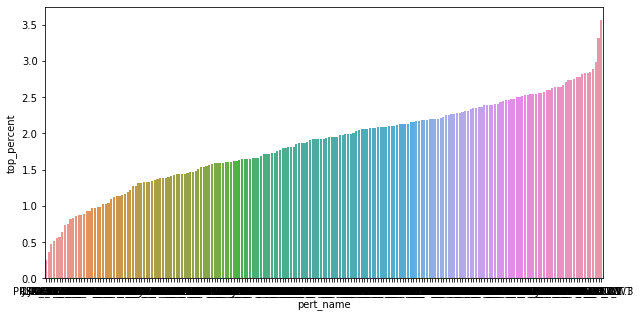

,pert_name,first_hit,std,top_percent,percent_group,coef_var,signal_noise
90,JUN_WT.2,25.76,79.221869,0.250340,1.0,3.075383,0.325163
133,PRKACA_WT.2,37.68,80.984362,0.366181,1.0,2.149267,0.465275
89,JUN_WT.1,48.70,169.526983,0.473275,1.0,3.481047,0.287270
46,CSNK1E_WT.2,53.30,89.134672,0.517979,1.0,1.672320,0.597972
56,DLL1_WT,56.76,120.526153,0.551603,1.0,2.123435,0.470935
147,RAF1_WT.1,58.86,112.042996,0.572012,1.0,1.903551,0.525334
65,ELK1_WT,66.20,95.791653,0.643343,1.0,1.447004,0.691083
37,CEBPA_WT.2,76.56,171.298660,0.744023,1.0,2.237443,0.446939
197,WWTR1_WT,76.74,141.570320,0.745773,1.0,1.844805,0.542063
31,CDC42_WT,83.88,88.635148,0.815160,1.0,1.056690,0.946351


In [18]:
# Visualization
sc_summary = summarize(sc_results)
sc_summary = visualize(sc_summary)
sc_summary.head(n=10)

# Image-level analysis

In [19]:
# Batch correction
image_controls = sc_control_features.groupby(["Metadata_Plate", "Metadata_Well", "Metadata_Site", "pert_name"]).mean().reset_index()
whN = profiling.WhiteningNormalizer(image_controls[feats], reg_param=REG_PARAM)

(672,) (672, 672)


In [20]:
# Profling
image_features = pd.concat((sc_treatments, pd.DataFrame(data=sc_features)), axis=1)
image_features = image_features.groupby(["Metadata_Plate", "Metadata_Well", "Metadata_Site", "pert_name"]).mean().reset_index()
whD = whN.normalize(image_features[feats])
image_features[feats] = whD

In [21]:
# Evaluation
img_results = find_first_hits(image_features, feats, PERT_NAME, CTRL_NAME)

1029it [03:17,  5.21it/s]


Treatments with hits in the top 1%: 103


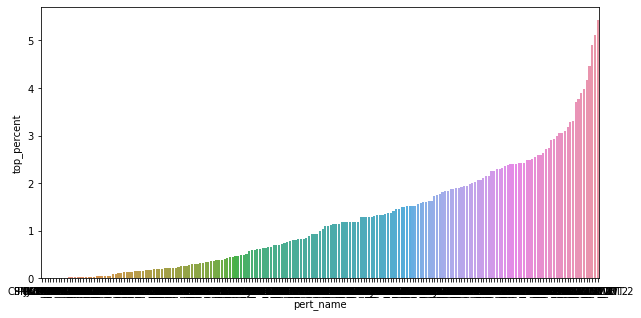

,pert_name,first_hit,std,top_percent,percent_group,coef_var,signal_noise
46,CSNK1E_WT.2,0.000000,0.000000,0.000000,0.0,NaN,NaN
140,PRKCE_WT.1,0.022222,0.149071,0.000240,1.0,6.708204,0.149071
90,JUN_WT.2,0.044444,0.298142,0.000480,1.0,6.708204,0.149071
89,JUN_WT.1,0.155556,0.424026,0.001680,1.0,2.725881,0.366854
75,GSK3B_WT.1,0.244444,1.494772,0.002640,1.0,6.114977,0.163533
197,WWTR1_WT,0.311111,2.086997,0.003360,1.0,6.708204,0.149071
130,PPARGC1A_WT.2,1.244444,5.343456,0.013439,1.0,4.293849,0.232891
26,BRAF_WT.2,1.577778,2.508974,0.017039,1.0,1.590195,0.628854
93,MAP2K3_WT,1.711111,4.197522,0.018479,1.0,2.453097,0.407648
37,CEBPA_WT.2,1.844444,1.870289,0.019918,1.0,1.014012,0.986182


In [22]:
# Visualization
img_summary = summarize(img_results)
img_summary = visualize(img_summary)
img_summary.head(n=10)

# Well-level analysis

In [23]:
# Batch correction
well_controls = sc_control_features.groupby(["Metadata_Plate", "Metadata_Well", "Metadata_Site", "pert_name"]).mean().reset_index()
well_controls = well_controls.groupby(["Metadata_Plate", "Metadata_Well", "pert_name"]).mean().reset_index()
whN = profiling.WhiteningNormalizer(well_controls[feats], reg_param=REG_PARAM)

(672,) (672, 672)


In [24]:
# Profiling
well_features = pd.concat((sc_treatments, pd.DataFrame(data=sc_features)), axis=1)
well_features = well_features.groupby(["Metadata_Plate", "Metadata_Well", "Metadata_Site", "pert_name", "broad_sample"]).mean().reset_index()
well_features = well_features.groupby(["Metadata_Plate", "Metadata_Well", "pert_name", "broad_sample"]).mean().reset_index()
whD = whN.normalize(well_features[feats])
well_features[feats] = whD

In [25]:
# Evaluation
well_results = find_first_hits(well_features, feats, PERT_NAME, CTRL_NAME)

1029it [00:37, 27.28it/s]


Treatments with hits in the top 1%: 103


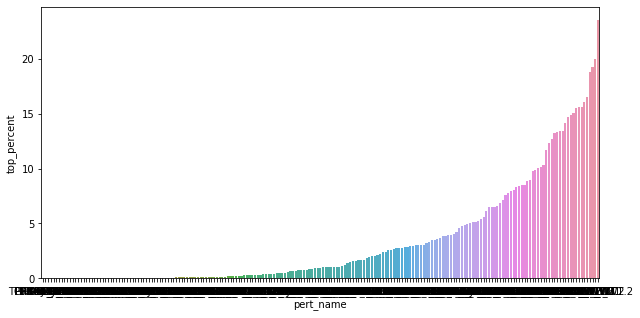

,pert_name,first_hit,std,top_percent,percent_group,coef_var,signal_noise
182,TGFBR1_WT.1,0.0,0.0,0.0,0.0,NaN,NaN
140,PRKCE_WT.1,0.0,0.0,0.0,0.0,NaN,NaN
54,DIABLO_WT,0.0,0.0,0.0,0.0,NaN,NaN
139,PRKACG_WT.3,0.0,0.0,0.0,0.0,NaN,NaN
153,REL_WT.1,0.0,0.0,0.0,0.0,NaN,NaN
65,ELK1_WT,0.0,0.0,0.0,0.0,NaN,NaN
132,PRKACA_WT.1,0.0,0.0,0.0,0.0,NaN,NaN
130,PPARGC1A_WT.2,0.0,0.0,0.0,0.0,NaN,NaN
89,JUN_WT.1,0.0,0.0,0.0,0.0,NaN,NaN
98,MAP3K9_WT,0.0,0.0,0.0,0.0,NaN,NaN


In [26]:
# Visualization
well_summary = summarize(well_results)
well_summary = visualize(well_summary)
well_summary.head(n=10)

# Treatment-level analysis

In [27]:
# Profiling
treatment_features = well_features.groupby(["pert_name", "broad_sample"]).mean().reset_index()
treatment_features = treatment_features.sort_values("broad_sample").reset_index(drop=True)

Treatments with ground truth: 205


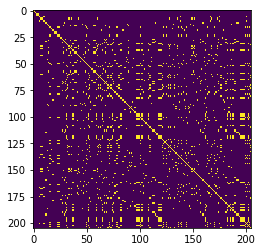

In [28]:
# Ground truth connections
X, Y = profiling.load_correlation_matrix(CORR_MATRIX)
Y["broad_sample"] = treatment_features.broad_sample
print("Treatments with ground truth:", np.sum(Y.broad_sample == Y.Var1))

moa_matches = []
for k,r in Y.iterrows():
    m = Y["Metadata_moa.x"] == r["Metadata_moa.x"]
    moa_matches.append(m)
moa_matches = np.asarray(moa_matches, dtype=np.uint8)
plt.imshow(moa_matches)

In [29]:
# Similarity search
F = treatment_features.loc[treatment_features[PERT_NAME] != CTRL_NAME, feats]
C = np.dot(F, F.T)
Fn = np.linalg.norm(F, axis=1)
cos = C / (Fn[:,np.newaxis] @ Fn[:,np.newaxis].T)
ranking = np.argsort(-cos, axis=1)

In [30]:
# First hits evaluation
results = []
for h in range(cos.shape[0]):
    hit = np.where(moa_matches[h, ranking[h]] == 1)[0]
    if len(hit) >= 2:
        hit = hit[1]
    else:
        hit = 0
        print(h, Y.loc[h, "Metadata_moa.x"])
    results.append({"broad_sample":treatment_features.loc[h, "broad_sample"], 
                    "pert_name":treatment_features.loc[h, "pert_name"],
                    "first_hit": hit,
                   })
results = pd.DataFrame(data=results)

2 Chromatin Modifiers
107 SMAD/ TGFb


Treatments with hits in the top 1%: 87


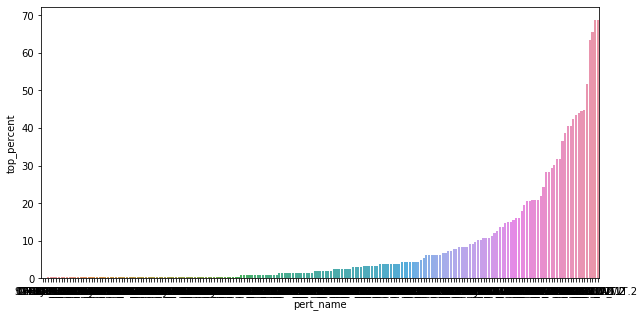

,broad_sample,pert_name,first_hit,top_percent
107,ccsbBroad304_00964,SMAD7_WT,0,0.000000
2,BRDN0000464848,CREBBP_WT,0,0.000000
0,BRDN0000464846,CEBPA_WT.1,1,0.487805
66,BRDN0000464936,GRB10_WT.2,1,0.487805
65,BRDN0000464935,MAP2K4_WT.1,1,0.487805
...,...,...,...,...
163,ccsbBroad304_06846,RB1_WT.2,106,51.707317
158,ccsbBroad304_06770,PRKAA1_WT.2,130,63.414634
178,ccsbBroad304_09091,SLIRP_WT.1,134,65.365854
26,BRDN0000464873,PPARGC1A_WT.2,141,68.780488


In [31]:
# Summary statistics per treatment
results["top_percent"] = (results["first_hit"] / len(results))*100
visualize(results)

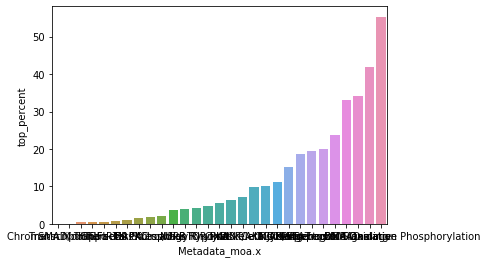

In [32]:
# Summary per MOA
moa_results = pd.merge(results, Y, on="broad_sample").groupby("Metadata_moa.x")["first_hit"].mean().reset_index()
moa_results["top_percent"] = (moa_results["first_hit"] / len(results))*100
moa_results = moa_results.sort_values("top_percent")
sb.barplot(data=moa_results, x="Metadata_moa.x", y="top_percent")
moa_results